<a href="https://colab.research.google.com/github/Amrutha369/voice-spoofing-detection/blob/main/voice_spoofing_detection_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

!pip install tensorflow-io
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import seaborn as sns
import joblib
from IPython.display import Audio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 14.7 MB/s eta 0:00:00


In [ ]:
# Audio params
SAMPLE_RATE = 16000
DURATION = 20.0 # duration in second
AUDIO_LEN = int(SAMPLE_RATE * DURATION)

# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 # time axis
HOP_LEN = 512 # non-overlap region
FMAX = SAMPLE_RATE//2 # max frequency

# CNN params
NUM_CLASSES = 2 # bonafide or spoof
BATCH_SIZE = 32 # adjust based on your memory
EPOCHS = 100 # adjust based on your time
LEARNING_RATE = 0.0001 # adjust based on your model performance
N_ESTIMATORS = 10
RANDOM_STATE = 42

In [ ]:
# Directory and protocol definitions
base_path = '/content/drive/MyDrive/dataset/LA'
protocol_dir = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols')
train_dir = os.path.join(base_path, 'ASVspoof2019_LA_train', 'flac')
dev_dir = os.path.join(base_path, 'ASVspoof2019_LA_dev', 'flac')
eval_dir = os.path.join(base_path, 'ASVspoof2019_LA_eval', 'flac')

In [ ]:
# Function to form the full path of a file
def get_file_path(directory, filename):
    return os.path.join(directory, f'{filename}.flac')

In [ ]:
# Function to read the dataset
def read_dataset(protocol_path, directory):
    """Reads the dataset from a protocol file and returns a DataFrame."""
    df = pd.read_csv(protocol_path, sep=' ', header=None, names=['speaker_id', 'filename', 'system_id', 'null', 'class_name'])
    df['filepath'] = df['filename'].apply(lambda x: get_file_path(directory, x))
    df.drop('null', axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

# Function to convert class_name to integer
def label_to_int(class_name):
    if class_name == 'bonafide':
        return 0
    else:
        return 1

# Add target column and subset to DataFrame
def add_columns(df, subset):
    df['target'] = df['class_name'].apply(label_to_int)
    df['subset'] = subset
    return df

# Take samples from each DataFrame by a different number
def sample_data(df, n_bonafide, n_spoof):
    bonafide = df[df['class_name'] == 'bonafide'].head(n_bonafide)
    spoof = df[df['class_name'] != 'bonafide'].head(n_spoof)
    return pd.concat([bonafide, spoof])

In [ ]:
# Create DataFrames for each dataset
train_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.train.trn.txt'), train_dir)
dev_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.dev.trl.txt'), dev_dir)
eval_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.eval.trl.txt'), eval_dir)

# Add columns to each DataFrame
train_df = add_columns(train_df, 'train')
dev_df = add_columns(dev_df, 'dev')
eval_df = add_columns(eval_df, 'eval')

# Take samples from each DataFrame by a different number
train_df = sample_data(train_df, 5, 5)
dev_df = sample_data(dev_df, 5, 5)
eval_df = sample_data(eval_df, 5, 5)

In [ ]:
#Combine three dataframes into one dataframe
data_df = pd.concat([train_df, dev_df, eval_df], ignore_index=True)

In [ ]:
data_df.head(len(data_df))

,speaker_id,filename,system_id,class_name,filepath,target,subset
0,LA_0079,LA_T_1138215,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
1,LA_0079,LA_T_1271820,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
2,LA_0079,LA_T_1272637,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
3,LA_0079,LA_T_1276960,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
4,LA_0079,LA_T_1341447,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
5,LA_0079,LA_T_1004644,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
6,LA_0079,LA_T_1056709,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
7,LA_0079,LA_T_1195221,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
8,LA_0079,LA_T_1265032,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
9,LA_0079,LA_T_1287124,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train


In [ ]:
def audio_to_spectrogram(filepath):
    # Membaca file audio
    audio = tfio.audio.AudioIOTensor(filepath)

    # Mengambil sampel audio dan mengubahnya menjadi float32
    audio_slice = audio.to_tensor()
    audio_tensor = tf.squeeze(audio_slice, axis=[-1])
    audio_tensor = tf.cast(audio_tensor, tf.float32)

    # Normalisasi audio
    tensor = tf.math.divide(
        tf.subtract(
            audio_tensor,
            tf.reduce_min(audio_tensor)
        ),
        tf.subtract(
            tf.reduce_max(audio_tensor),
            tf.reduce_min(audio_tensor)
        )
    )

     # Mengubah audio menjadi spektrogram
    spectrogram = tfio.audio.spectrogram(
        tensor,
        nfft=N_FFT,
        window=N_FFT,
        stride=HOP_LEN
    )

    # Mengubah spektrogram menjadi skala Mel
    mel_spectrogram = tfio.audio.melscale(
        spectrogram,
        rate=SAMPLE_RATE,
        mels=N_MELS,
        fmin=0,
        fmax=FMAX
    )

    # Mengubah skala Mel menjadi desibel
    mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    # Menambahkan dimensi saluran
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)

    # Mengubah ukuran spektrogram menjadi ukuran yang ditentukan
    image = tf.image.resize(mel_spectrogram, [SPEC_WIDTH, N_MELS])

    return image

# Menambahkan kolom spektrogram ke DataFrame
data_df['spectrogram'] = data_df['filepath'].apply(audio_to_spectrogram)

In [ ]:
data_df.head(len(data_df))

,speaker_id,filename,system_id,class_name,filepath,target,subset,spectrogram
0,LA_0079,LA_T_1138215,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train,"(((tf.Tensor(43.36773, shape=(), dtype=float32..."
1,LA_0079,LA_T_1271820,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train,"(((tf.Tensor(43.683586, shape=(), dtype=float3..."
2,LA_0079,LA_T_1272637,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train,"(((tf.Tensor(44.08663, shape=(), dtype=float32..."
3,LA_0079,LA_T_1276960,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train,"(((tf.Tensor(41.973137, shape=(), dtype=float3..."
4,LA_0079,LA_T_1341447,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train,"(((tf.Tensor(43.1888, shape=(), dtype=float32)..."
5,LA_0079,LA_T_1004644,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train,"(((tf.Tensor(45.131607, shape=(), dtype=float3..."
6,LA_0079,LA_T_1056709,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train,"(((tf.Tensor(43.86258, shape=(), dtype=float32..."
7,LA_0079,LA_T_1195221,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train,"(((tf.Tensor(44.409046, shape=(), dtype=float3..."
8,LA_0079,LA_T_1265032,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train,"(((tf.Tensor(44.207954, shape=(), dtype=float3..."
9,LA_0079,LA_T_1287124,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train,"(((tf.Tensor(43.67731, shape=(), dtype=float32..."


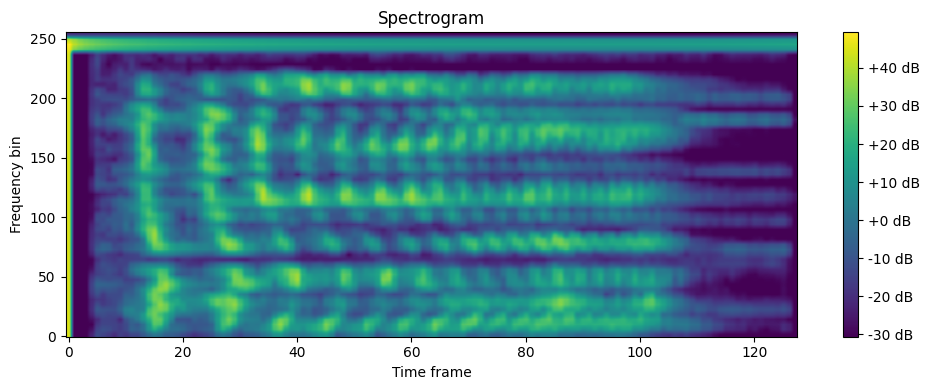

In [ ]:
# Pilih spektrogram dari DataFrame
first_spectrogram = data_df.loc[5, 'spectrogram']

# Gunakan fungsi imshow untuk menampilkan spektrogram
plt.figure(figsize=(10, 4))
plt.imshow(tf.squeeze(first_spectrogram), aspect='auto', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Frequency bin')
plt.xlabel('Time frame')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
print("Ukuran spektrogram adalah :", first_spectrogram.shape)

In [ ]:
# Membagi data berdasarkan kolom 'subset'
train_data = data_df[data_df['subset'] == 'train']
dev_data = data_df[data_df['subset'] == 'dev']
eval_data = data_df[data_df['subset'] == 'eval']

# Mengubah list spektrogram menjadi array NumPy
X_train = np.stack(train_data['spectrogram'].to_list())
X_dev = np.stack(dev_data['spectrogram'].to_list())
X_eval = np.stack(eval_data['spectrogram'].to_list())

# Mengubah target menjadi array NumPy
y_train = train_data['target'].to_numpy()
y_dev = dev_data['target'].to_numpy()
y_eval = eval_data['target'].to_numpy()

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_dev shape: {X_dev.shape}")
print(f"y_dev shape: {y_dev.shape}")
print(f"X_eval shape: {X_eval.shape}")
print(f"y_eval shape: {y_eval.shape}")

X_train shape: (10, 256, 128, 1)
y_train shape: (10,)
X_dev shape: (10, 256, 128, 1)
y_dev shape: (10,)
X_eval shape: (10, 256, 128, 1)
y_eval shape: (10,)


In [ ]:
def create_cnn_model(input_shape):
    model = Sequential()
    # 1st conv layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 2nd conv layer
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 3rd conv layer
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 4th conv layer
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Additional dense layer
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create the CNN model
cnn_model = create_cnn_model((X_train.shape[1], X_train.shape[2], 1))


In [ ]:
# Display the summary of the CNN model
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 63, 32)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 63, 32)       128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 61, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 31, 32)        0         
 g2D)                                                            
                                                        

In [ ]:
# Train the CNN model
cnn_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.5973 - accuracy: 0.7000
Epoch 2/100
1/1 [==============================] - 0s 450ms/step - loss: 0.4834 - accuracy: 0.7000
Epoch 3/100
1/1 [==============================] - 0s 439ms/step - loss: 0.2996 - accuracy: 0.9000
Epoch 4/100
1/1 [==============================] - 0s 438ms/step - loss: 0.3544 - accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 432ms/step - loss: 0.1591 - accuracy: 0.9000
Epoch 6/100
1/1 [==============================] - 0s 445ms/step - loss: 0.1300 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 426ms/step - loss: 0.0452 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 438ms/step - loss: 0.0855 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 452ms/step - loss: 0.0890 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 494ms/step - loss: 0.1413 - accuracy: 1.0000
Epoch 11/100

In [ ]:


# Save the model
cnn_model.save('/content/drive/MyDrive/save/voice-spoofing-detection-using-cnn.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Compute accuracy on training data
train_accuracy = cnn_model.evaluate(X_train, y_train)[1]
print(f"Accuracy on training data: {train_accuracy * 100:.2f}%")

# Compute accuracy on validation data
val_accuracy = cnn_model.evaluate(X_dev, y_dev)[1]
print(f'Accuracy on validation data: {val_accuracy * 100:.2f}%')

# Compute accuracy on test data
test_accuracy = cnn_model.evaluate(X_eval, y_eval)[1]
print(f'Accuracy on test data: {test_accuracy * 100:.2f}%')


1/1 [==============================] - 0s 378ms/step - loss: 0.0666 - accuracy: 1.0000
Accuracy on training data: 100.00%
1/1 [==============================] - 0s 125ms/step - loss: 0.3777 - accuracy: 0.8000
Accuracy on validation data: 80.00%
1/1 [==============================] - 0s 122ms/step - loss: 0.3683 - accuracy: 0.7000
Accuracy on test data: 70.00%


In [ ]:
# Fetching one bonafide file from the 'eval' subset
bonafide_file = data_df[(data_df['class_name'] == 'spoof') & (data_df['subset'] == 'eval')].iloc[0]

# Fetching one spoof file from the 'eval' subset
spoof_file = data_df[(data_df['class_name'] == 'spoof') & (data_df['subset'] == 'train')].iloc[0]

# Creating spectrograms for both files
bonafide_spectrogram = audio_to_spectrogram(bonafide_file['filepath'])
spoof_spectrogram = audio_to_spectrogram(spoof_file['filepath'])
X_new = np.stack([bonafide_spectrogram, spoof_spectrogram])

# Performing prediction
y_pred_prob = cnn_model.predict(X_new)
y_pred = np.argmax(y_pred_prob, axis=1)

# Creating a dictionary for mapping
class_dict = {0: 'bonafide', 1: 'spoof'}

# Applying mapping to predictions
y_pred_classes = [class_dict[i] for i in y_pred]

# Printing the results
for i, pred in enumerate(y_pred_classes):
    print(f"File {i+1} is {pred}")


1/1 [==============================] - 0s 191ms/step
File 1 is bonafide
File 2 is bonafide


In [ ]:
import os

# Define the paths to the bonafide and spoof audio files
bonafide_file_path = "/content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_train/flac/LA_T_1138215.flac"
spoof_file_path = "/content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_train/flac/LA_T_1004644.flac"

# Creating spectrograms for both files
bonafide_spectrogram = audio_to_spectrogram(bonafide_file_path)
spoof_spectrogram = audio_to_spectrogram(spoof_file_path)
X_new = np.stack([bonafide_spectrogram, spoof_spectrogram])

# Performing prediction
y_pred_prob = cnn_model.predict(X_new)
y_pred = np.argmax(y_pred_prob, axis=1)

# Creating a dictionary for mapping
class_dict = {0: 'bonafide', 1: 'spoof'}

# Applying mapping to predictions
y_pred_classes = [class_dict[i] for i in y_pred]

# Printing the results
for i, pred in enumerate(y_pred_classes):
    print(f"File {i+1} is {pred}")


1/1 [==============================] - 0s 40ms/step
File 1 is bonafide
File 2 is bonafide


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have X_eval and y_eval datasets for testing

# Perform predictions on the evaluation set
y_eval_pred = cnn_model.predict(X_eval)

# Convert predictions to binary labels (0 or 1)
y_eval_pred_binary = (y_eval_pred > 0.5).astype(int)

# Calculate classification report
report = classification_report(y_eval, y_eval_pred_binary, target_names=class_dict.values())

# Print report
print(report)


1/1 [==============================] - 0s 113ms/step
              precision    recall  f1-score   support

    bonafide       0.62      1.00      0.77         5
       spoof       1.00      0.40      0.57         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10



1/1 [==============================] - 0s 192ms/step


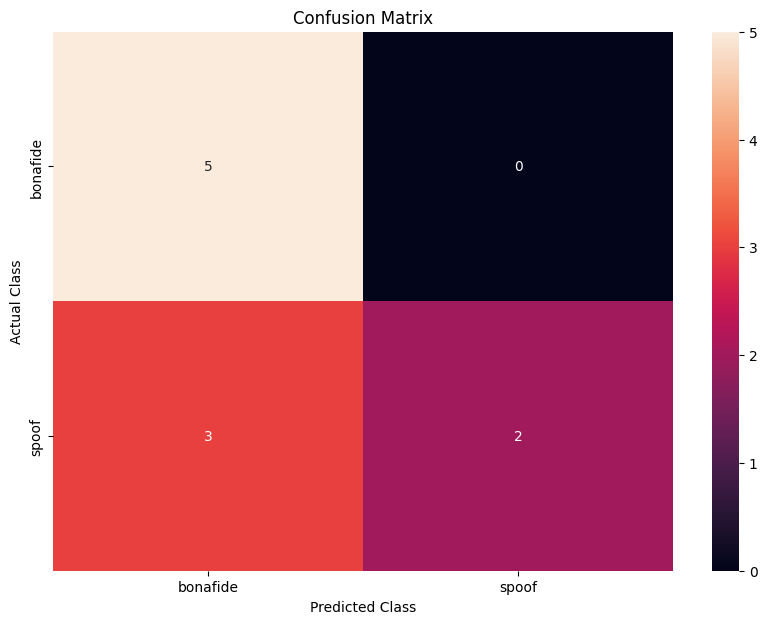

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have X_eval and y_eval datasets for testing

# Perform predictions on the evaluation set
y_eval_pred = cnn_model.predict(X_eval)

# Convert predictions to binary labels (0 or 1)
y_eval_pred_binary = (y_eval_pred > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_eval, y_eval_pred_binary)

# Create a heatmap plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_dict.values(), yticklabels=class_dict.values())
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Show the plot
plt.show()
